# Estimation of OHM staking yield
## By Jacky Li

A personal project estimating the staking yield of OHM token. <br>
All data queried from Dune Analytics. <br>
Queries partially taken from @sha4dow on Dune Analytics.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import timedelta
import datetime

### Preprocessing and understanding the data

Get the supply history of OHM

In [2]:
supply = pd.read_csv("supply_history.csv", header = None)

In [3]:
supply = supply.dropna(axis = 'rows', how = 'all')
supply = supply.dropna(axis = 'columns', how = 'all')

In [4]:
supply = supply[::-1]
supply.columns =["Date", "Total Supply", "Circulating Supply", "Index"]

In [5]:
supply

,Date,Total Supply,Circulating Supply,Index
244,3/23/21,6.826000e+04,5.851802e+04,0.0000
243,3/24/21,6.826000e+04,5.864180e+04,0.0021
242,3/25/21,6.896281e+04,5.947480e+04,0.0164
241,3/26/21,6.974178e+04,6.047318e+04,0.0334
240,3/27/21,7.063727e+04,6.149922e+04,0.0509
...,...,...,...,...
4,11/18/21,5.477576e+06,4.514706e+06,76.1507
3,11/19/21,5.522418e+06,4.559767e+06,76.9207
2,11/20/21,5.581109e+06,4.621031e+06,77.9677
1,11/21/21,5.644007e+06,4.683242e+06,79.0308


In [6]:
dates = pd.date_range("2021-03-23", "2021-11-22")

We are interested in predicting the circulating supply in order to predict the reward rate, which allows us to calculate the yield

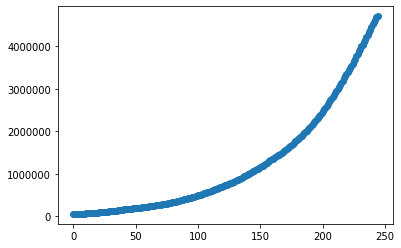

In [7]:
#circulating supply
plt.scatter(np.arange(245), supply.iloc[:,2])
plt.show()

From the plot, we see that circulating supply shows a exponential pattern, thus, try to fit a exponential function to the supply curve.

### Miscellaneous exploratory data analysis

In [8]:
circ_supply = np.array(supply.iloc[:,2].tolist())

In [9]:
idx_std = np.arange(245)/244

In [10]:
#increase in circulating supply and increase in total supply (past 30 days))
d30_circ = circ_supply[-31:-1]
tot_supply = np.array(supply.iloc[:,1].tolist())
d30_tot = tot_supply[-31:-1]
inc_circ = np.zeros(29)
inc_tot = np.zeros(29)
for i in np.arange(29):
    inc_circ[i] = d30_circ[i+1] - d30_circ[i]
    inc_tot[i] = d30_tot[i+1] - d30_tot[i]

<function matplotlib.pyplot.show(*args, **kw)>

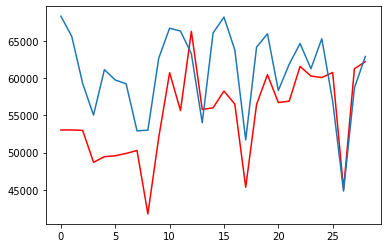

In [11]:
plt.plot(np.arange(29), inc_circ, color = 'red')
plt.plot(np.arange(29), inc_tot)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

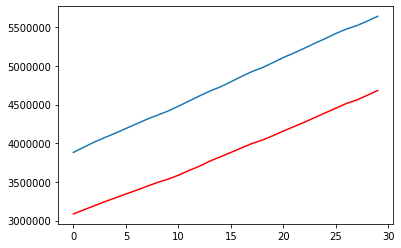

In [12]:
plt.plot(np.arange(30), d30_circ, color = 'red')
plt.plot(np.arange(30), d30_tot)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

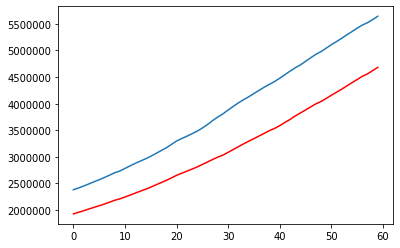

In [13]:
d60_circ = circ_supply[-61:-1]
d60_tot = tot_supply[-61:-1]
plt.plot(np.arange(60), d60_circ, color = 'red')
plt.plot(np.arange(60), d60_tot)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

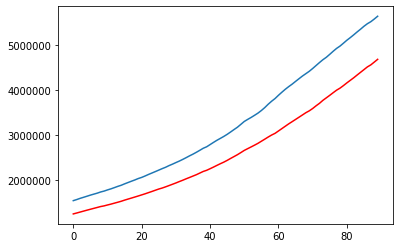

In [14]:
d90_circ = circ_supply[-91:-1]
d90_tot = tot_supply[-91:-1]
plt.plot(np.arange(90), d90_circ, color = 'red')
plt.plot(np.arange(90), d90_tot)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

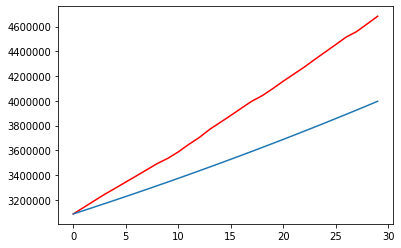

In [15]:
#how much of the increase in circulating supply comes from staking
d30_circ_stk = np.zeros(30)
d30_circ_stk[0] = d30_circ[0]
for i in np.arange(29):
    d30_circ_stk[i+1]=d30_circ_stk[i] * (1.002975)**3
plt.plot(np.arange(30), d30_circ, color = 'red')
plt.plot(np.arange(30), d30_circ_stk)
plt.show

significant amount of of increase in supply did not come from staking

In [16]:
#how much exactly does staking reward constitutes in each day's supply
d30_stk_pct = np.zeros(29)
for i in np.arange(29):
    d30_stk_pct[i] = (d30_circ[i+1] - d30_circ[i] * (1.002975)**3)/(d30_circ[i+1] - d30_circ[i])
print(d30_stk_pct)

[0.47918137 0.47027067 0.46077152 0.40357948 0.40386968 0.39636307
 0.39127651 0.38724682 0.25151661 0.39215109 0.47129142 0.41326601
 0.49985864 0.39524247 0.38870319 0.40378538 0.37595011 0.21135011
 0.35941848 0.39337768 0.34379658 0.3369684  0.378974   0.35647785
 0.34537102 0.34377411 0.10312884 0.33375134 0.33507107]


Not much!

### Fitting and predicting OHM supply

In [17]:
def exponential (x,a,b,c):
    return a*np.exp(b*x)+c

In [18]:
params, covs = curve_fit(exponential, idx_std, circ_supply)

In [19]:
a, b, c = params
params

array([ 1.40268811e+05,  3.55591906e+00, -1.00584911e+05])

Thus, the supply $y$ follow the formula with respect to $x$ (days since 3/23/21): $y=140268e^{3.56x}-100584$

In [20]:
y_pred = a*np.exp(idx_std*b)+c
y_pred[-1]

4811627.52438348

Compare the predicted value with the labels

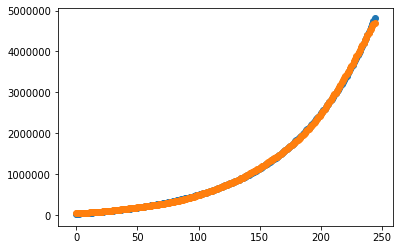

In [21]:
plt.scatter(np.arange(245), y_pred)
plt.scatter(np.arange(245), circ_supply)
plt.show()

In [28]:
#fing the r squared
ss_res = np.sum((y_pred - circ_supply)**2)
ss_tot = np.sum((circ_supply-np.mean(circ_supply))**2)
r2 = 1-(ss_res/ss_tot)
r2

0.9998491276211584

It's a weird phenomena that we have such a high $R^2$ - over 99%. A possible theory would be the policy team is deliberatly targeting this curve. It would be interesting to see what the supply is like in the future and if it maintains this trend.

Note: While this method is very likely to overestimate the OHM supply, especially far into the future, for a shorter timeframe it is likely to give a relativly accurate result. It would take drastic change in the policy, or staking/bonding activities to deviate the curve from its current form significantly. Since we are looking to estimate the yield for the next 6 month - 1 year, this curve should give a reasonable estimate. And the supply curve will almost always remain an exponential curve since the staking rewards are distributed based on the current circulating OHMs. Unless the DAO starts buying back OHM and burning them, the curve will always be convex. And if that were to really happpen (burning OHM), it would mean that OHM price drops below 1USD. Given the current price of around 800USD, that would be a disasterous outcome no matter the yield.


### Find the corresponding reward rate based on the supply schedule

In [76]:
#find the day circulating supply reaches 10m
days_till_10m = np.log((10000000-c)/a)/b
start_time = pd.to_datetime('2021-3-23')
date_10m = start_time + timedelta(int(days_till_10m*244))
print(date_10m)

2022-01-10 00:00:00


In [77]:
#find the day circ supply reaches 100m
days_till_100m = np.log((100000000-c)/a)/b
date_100m = start_time + timedelta(int(days_till_100m*244))
print(date_100m)

2022-06-16 00:00:00


In [78]:
#find the day circ supply reaches 1b
days_till_1b = np.log((1000000000-c)/a)/b
date_1b = start_time + timedelta(int(days_till_1b*244))
print(date_1b)

2022-11-21 00:00:00


According to OlympusDao documents, the reward rate per epoch when the supply is between 10 and 100m will be between 0.1186% to 0.1587%. Thus, we propose three cases for the reward rate, being low, mid, high, respectivly.

In [79]:
#based on the exponential model, what would be the yield like
rate_10m = (1+(0.002957/0.9))**3
rate_100m_h = (1+(0.001587/0.9))**3
rate_100m_m = (1+(0.0013/0.9))**3
rate_100m_l = (1+(0.001186/0.9))**3
init_ohm = 1
init_date = pd.to_datetime('2021-11-23')

Based on the reward rates, find the yield based on each cases

amount I own on 2022-06-16 00:00:00 for staking 1 OHM: 3.677168682369163 OHMs


<function matplotlib.pyplot.show(*args, **kw)>

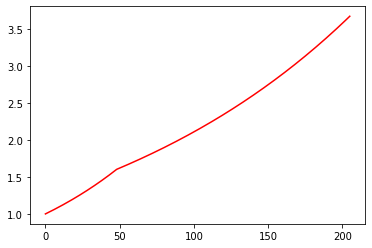

In [86]:
#amount of ohm owned till total supply reaches 100m
days_till_100m = (date_100m - init_date).days
days_till_10m = (date_10m - init_date).days
#high
iown_h = np.zeros(days_till_100m+1)
iown_h[0] = init_ohm
for i in np.arange(days_till_10m):
    iown_h[i+1] = iown_h[i] * rate_10m
for i in np.arange(days_till_10m, days_till_100m):
    iown_h[i+1] = iown_h[i] * rate_100m_h
print(f'Amount I own on {date_100m} for staking {init_ohm} OHM: {iown_h[-1]} OHMs')
plt.plot(np.arange(days_till_100m+1), iown_h, color = 'red')
plt.show

Amount I own on 2022-06-16 00:00:00 for staking 1 OHM: 3.1651071868961864 OHMs


<function matplotlib.pyplot.show(*args, **kw)>

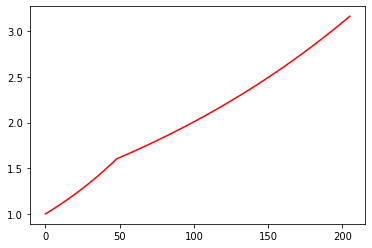

In [87]:
#mid
iown_m = np.zeros(days_till_100m+1)
iown_m[0] = init_ohm
for i in np.arange(days_till_10m):
    iown_m[i+1] = iown_m[i] * rate_10m
for i in np.arange(days_till_10m, days_till_100m):
    iown_m[i+1] = iown_m[i] * rate_100m_m
print(f'Amount I own on {date_100m} for staking {init_ohm} OHM: {iown_m[-1]} OHMs')
plt.plot(np.arange(days_till_100m+1), iown_m, color = 'red')
plt.show

Amount I own on 2022-06-16 00:00:00 for staking 1 OHM: 2.982044695639261 OHMs


<function matplotlib.pyplot.show(*args, **kw)>

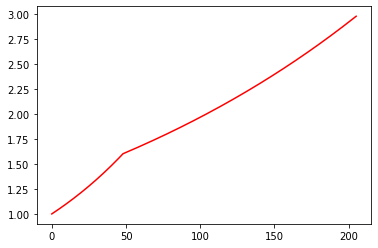

In [88]:
#low
iown_l = np.zeros(days_till_100m+1)
iown_l[0] = init_ohm
for i in np.arange(days_till_10m):
    iown_l[i+1] = iown_l[i] * rate_10m
for i in np.arange(days_till_10m, days_till_100m):
    iown_l[i+1] = iown_l[i] * rate_100m_l
print(f'Amount I own on {date_100m} for staking {init_ohm} OHM: {iown_l[-1]} OHMs')
plt.plot(np.arange(days_till_100m+1), iown_l, color = 'red')
plt.show

### Conclusion

Based on the analysis, for each OHM staked, it will turn into roughly 3.7 OHM in the best case and 3 OHM is the worse case. This might seem compelling for a 7-month timeframe. However, that beleif is built on the premise that OHM holds its value against the dollar, which is quite unlikely. The current OHM price is driven up by the artificial supply shortage created by the extraordinarily high staking rewards. Eventually, as people try to realize their gains and the APY gets lower, there will be mounting selling pressure that's going to drive down the price. 